## Fitting models with pipelines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

## Read in the data

In [3]:
data_url = 'https://raw.githubusercontent.com/jyurko/CMPINF_2100_Fall_2020/master/week_13/quadratic_demo_data.csv'

demo_df = pd.read_csv(data_url)

demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   30 non-null     int64  
 1   x       30 non-null     float64
 2   y       30 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 848.0 bytes


Visualize the data with Seaborn.

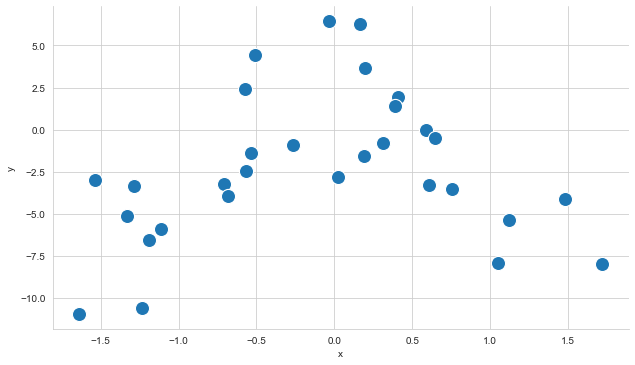

In [4]:
sns.set_style('whitegrid')

sns.relplot(data = demo_df, x='x', y='y', s=200, aspect=1.75)

plt.show()

Fit a linear trend within Seaborn.

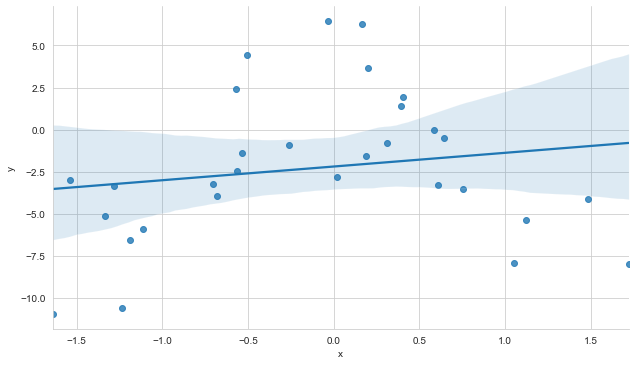

In [5]:
sns.lmplot(data = demo_df, x='x', y='y', aspect=1.75)

plt.show()

Fit a quadratic polynomial and visualize within Seaborn.

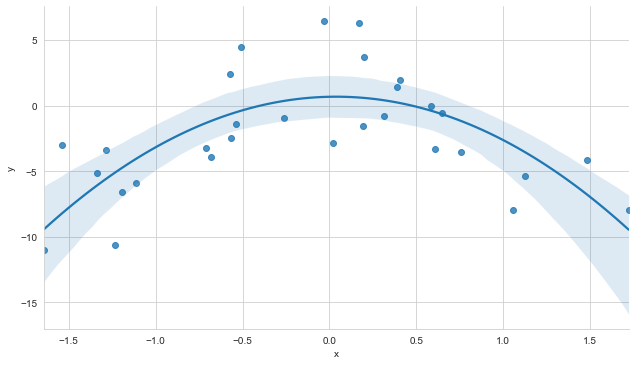

In [6]:
sns.lmplot(data = demo_df, x='x', y='y', order=2, aspect=1.75)

plt.show()

We can consider a non-linear smoother...

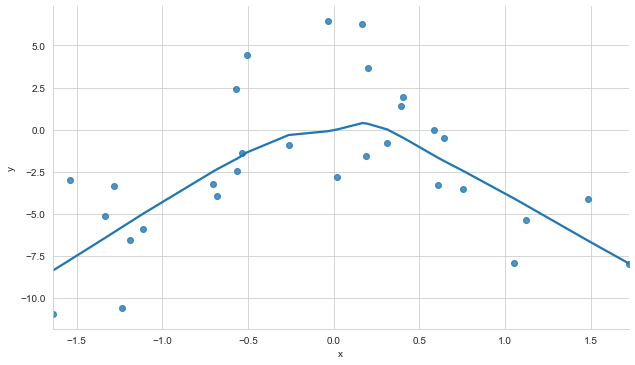

In [7]:
sns.lmplot(data = demo_df, x='x', y='y', lowess=True, aspect=1.75)

plt.show()

## Linear model without penalization

We will consider the most complex polynomial from the reading, the 8th degree polynomial.

In [8]:
formula_8 = 'y ~ x + np.power(x,2) + np.power(x,3) + np.power(x,4) + np.power(x,5) + np.power(x,6) + np.power(x,7) + np.power(x,8) - 1'

Create the response and input feature arrays with `dmatrices()` and our defined formula.

In [9]:
y_sk, X_sk = dmatrices(formula_8, data = demo_df)

In [10]:
print( type(y_sk) )

print( type(X_sk) )

<class 'patsy.design_info.DesignMatrix'>
<class 'patsy.design_info.DesignMatrix'>


In [11]:
print( X_sk.shape )

(30, 8)


In [13]:
print( y_sk.shape )

(30, 1)


sklearn wants the responses to be 1D arrays. So the `.ravel()` method forces the array to be 1D instead of 2D.

In [17]:
print( y_sk.ndim )

print( y_sk.ravel().shape )

print( y_sk.ravel().ndim )

2
(30,)
1


In [12]:
X_sk[:5, :]

array([[-2.62909616e-01,  6.91214661e-02, -1.81726981e-02,
         4.77777707e-03, -1.25612353e-03,  3.30246956e-04,
        -8.68251002e-05,  2.28271537e-05],
       [ 5.86243864e-01,  3.43681869e-01,  2.01481387e-01,
         1.18117227e-01,  6.92454995e-02,  4.05947492e-02,
         2.37984227e-02,  1.39516793e-02],
       [ 4.05812911e-01,  1.64684119e-01,  6.68309418e-02,
         2.71208590e-02,  1.10059948e-02,  4.46637478e-03,
         1.81251255e-03,  7.35540995e-04],
       [ 6.45776664e-01,  4.17027499e-01,  2.69306627e-01,
         1.73911935e-01,  1.12308269e-01,  7.25260595e-02,
         4.68356367e-02,  3.02453612e-02],
       [ 1.05380698e+00,  1.11050915e+00,  1.17026229e+00,
         1.23323057e+00,  1.29958698e+00,  1.36951383e+00,
         1.44320323e+00,  1.52085764e+00]])

Fit the linear regression model with sklearn, by estimating the coefficients that MINIMIZE the error as much as possible on the training set.

In [14]:
lm_fit = LinearRegression().fit(X_sk, y_sk.ravel())

Check the coefficients, starting with the intercept.

In [15]:
lm_fit.intercept_

2.291462463315684

The coefficients or the slopes that were estimated.

In [16]:
lm_fit.coef_

array([ -2.16808862,  -5.44397398,   8.49716225, -14.75809136,
        -7.58389605,  14.32500159,   1.86332798,  -3.18832181])

## Lasso regression tune with CV

Let's use the built-in cross-validation method for Lasso.

In [18]:
from sklearn.linear_model import LassoCV

Let's use 5-fold cross-validation.

In [19]:
kf05 = KFold(n_splits=5, shuffle=True, random_state=101)

Tune the lasso regression model, by tuning the regularization strenght `alpha`. Try out 101 different values of `alpha`. Therefore, the 5-fold cross-validation will be applied to each value and so there are 505 total models to fit.

In [20]:
lasso_cv = LassoCV(cv=kf05, n_alphas=101, max_iter=10001).fit(X_sk, y_sk.ravel())

Look at the optimal value of `alpha`.

In [21]:
lasso_cv.alpha_

0.5327466410790653

The coefficients associated with the best performing `alpha`. 

In [22]:
lasso_cv.intercept_

0.008965935290868643

In [23]:
lasso_cv.coef_

array([ 0.        , -2.50317921,  0.        , -0.16543405,  0.        ,
       -0.        ,  0.02658886, -0.        ])

Compare the lasso estimates to the coefficients from the original un-penalized model.

In [24]:
pd.DataFrame({'no_penalty': [lm_fit.intercept_] + list(lm_fit.coef_),
             'best_lasso': [lasso_cv.intercept_] + list(lasso_cv.coef_)})

,no_penalty,best_lasso
0,2.291462,0.008966
1,-2.168089,0.000000
2,-5.443974,-2.503179
3,8.497162,0.000000
4,-14.758091,-0.165434
5,-7.583896,0.000000
6,14.325002,-0.000000
7,1.863328,0.026589
8,-3.188322,-0.000000


Visualize the cross-validation performance, by plotting the "MSE path".

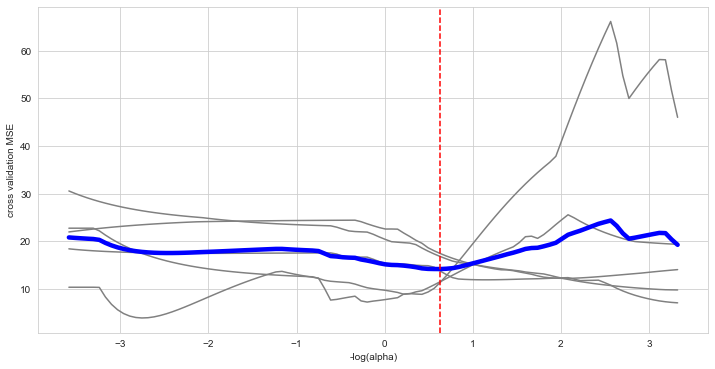

In [25]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(-np.log(lasso_cv.alphas_), lasso_cv.mse_path_, color='grey')
ax.plot(-np.log(lasso_cv.alphas_), lasso_cv.mse_path_.mean(axis=1), color='blue', linewidth=4.5)
ax.axvline(x = -np.log(lasso_cv.alpha_), color='red', linestyle='dashed')
ax.set_xlabel('-log(alpha)')
ax.set_ylabel('cross validation MSE')

plt.show()

Visualize the standard error on the average MSE with Seaborn, by reshaping the data from wide to long format.

In [26]:
resample_names = ['R' + str(x).zfill(2) for x in range(lasso_cv.mse_path_.shape[1])]

In [27]:
resample_names

['R00', 'R01', 'R02', 'R03', 'R04']

The data frame below has one row for each value of `alpha` and one column for each cross-validation fold.

In [28]:
mse_path_df = pd.DataFrame(lasso_cv.mse_path_, columns=resample_names)

mse_path_df

,R00,R01,R02,R03,R04
0,30.550100,10.314994,22.724465,18.385268,21.936878
1,30.029257,10.314994,22.724465,18.262287,22.097850
2,29.550091,10.314994,22.724465,18.154153,22.252317
3,29.108929,10.314994,22.724465,18.059019,22.400168
4,28.702457,10.314994,22.724465,17.975269,22.541365
...,...,...,...,...,...
96,9.923628,56.691845,19.624138,7.671868,13.547107
97,9.847385,58.171850,19.542057,7.440124,13.672785
98,9.788981,58.121808,19.466586,7.262456,13.793397
99,9.764459,51.672313,19.397071,7.130260,13.908849


Add in the negative log of `alpha`, to be consistent with the sklearn logistic regression penalization approach.

In [29]:
mse_path_df['neg_log_alpha'] = pd.Series( -np.log(lasso_cv.alphas_), index=mse_path_df.index)

In [30]:
mse_path_df

,R00,R01,R02,R03,R04,neg_log_alpha
0,30.550100,10.314994,22.724465,18.385268,21.936878,-3.584021
1,30.029257,10.314994,22.724465,18.262287,22.097850,-3.514944
2,29.550091,10.314994,22.724465,18.154153,22.252317,-3.445866
3,29.108929,10.314994,22.724465,18.059019,22.400168,-3.376789
4,28.702457,10.314994,22.724465,17.975269,22.541365,-3.307711
...,...,...,...,...,...,...
96,9.923628,56.691845,19.624138,7.671868,13.547107,3.047424
97,9.847385,58.171850,19.542057,7.440124,13.672785,3.116501
98,9.788981,58.121808,19.466586,7.262456,13.793397,3.185579
99,9.764459,51.672313,19.397071,7.130260,13.908849,3.254656


Reshape into long-format.

In [31]:
mse_path_lf = mse_path_df.melt(id_vars=['neg_log_alpha'], value_vars=resample_names, ignore_index=True)

In [32]:
mse_path_lf

,neg_log_alpha,variable,value
0,-3.584021,R00,30.550100
1,-3.514944,R00,30.029257
2,-3.445866,R00,29.550091
3,-3.376789,R00,29.108929
4,-3.307711,R00,28.702457
...,...,...,...
500,3.047424,R04,13.547107
501,3.116501,R04,13.672785
502,3.185579,R04,13.793397
503,3.254656,R04,13.908849


Visualize the standard error on the average MSE per `alpha`.

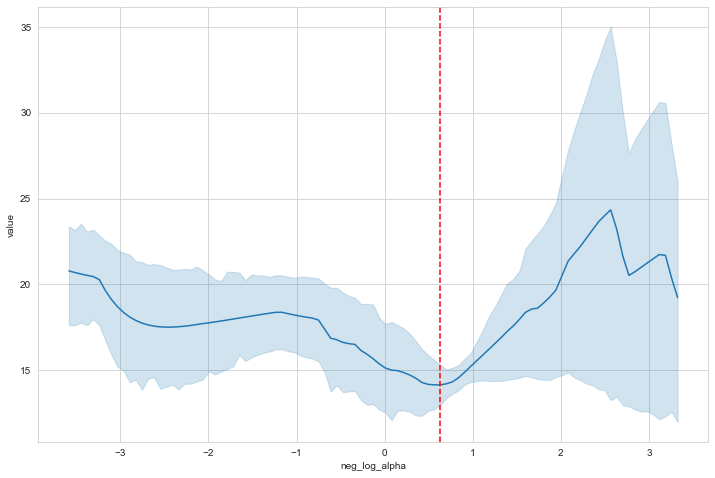

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data = mse_path_lf, x='neg_log_alpha', y='value', ci=68, ax=ax)

ax.axvline(x = -np.log(lasso_cv.alpha_), color='red', linestyle='dashed')

plt.show()

For additional context, let's include the individual fold MSE paths.

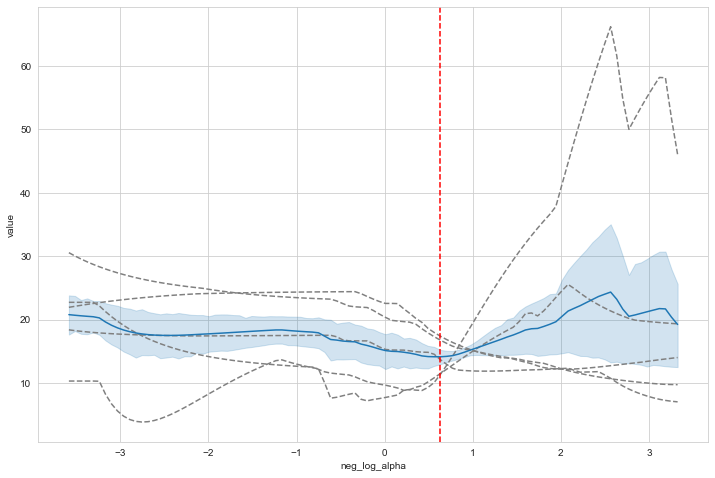

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data = mse_path_lf, x='neg_log_alpha', y='value', 
            estimator=None, units='variable', color='grey', linestyle='dashed')

sns.lineplot(data = mse_path_lf, x='neg_log_alpha', y='value', ci=68, ax=ax)

ax.axvline(x = -np.log(lasso_cv.alpha_), color='red', linestyle='dashed')

plt.show()

### coefficient interpretation

In [35]:
path_res = lasso_cv.path(X_sk, y_sk.ravel(), n_alphas=101, max_iter=10001)

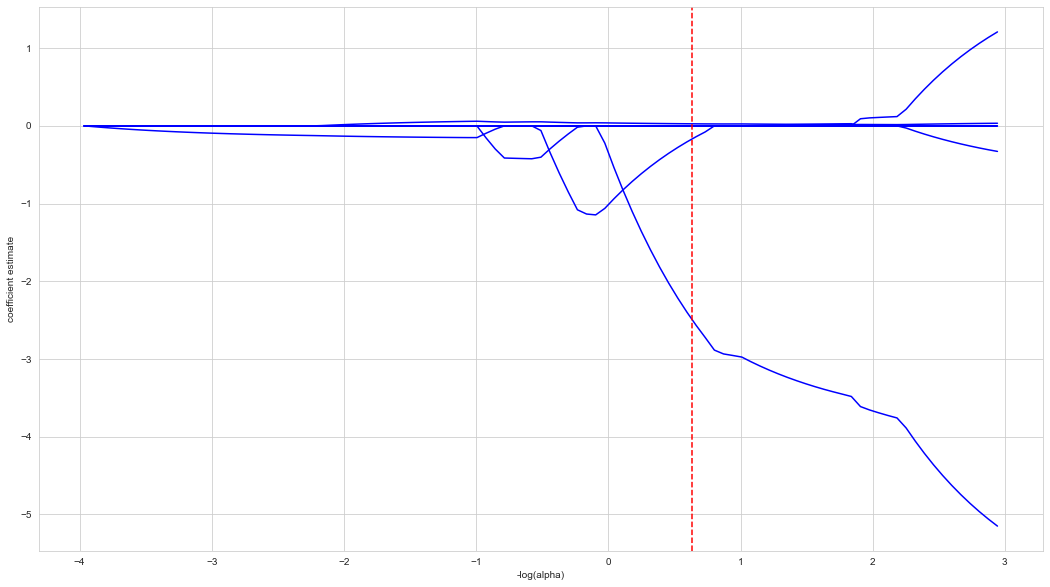

In [36]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(-np.log(path_res[0]), path_res[1].T, 'b-')

ax.axvline(x = -np.log(lasso_cv.alpha_), color='red', linestyle='dashed')

ax.set_xlabel('-log(alpha)')
ax.set_ylabel('coefficient estimate')

plt.show()

## Standardization and preprocessing

What we did before is not entirely correct...we need to standardize the features before applying lasso or ridge regression.

In [37]:
feature_names = ['np.power(x, %d)' % (d+1) for d in range(0, 8)]

In [38]:
feature_names

['np.power(x, 1)',
 'np.power(x, 2)',
 'np.power(x, 3)',
 'np.power(x, 4)',
 'np.power(x, 5)',
 'np.power(x, 6)',
 'np.power(x, 7)',
 'np.power(x, 8)']

Look at the boxplot to summarize the polynomial features in our model.

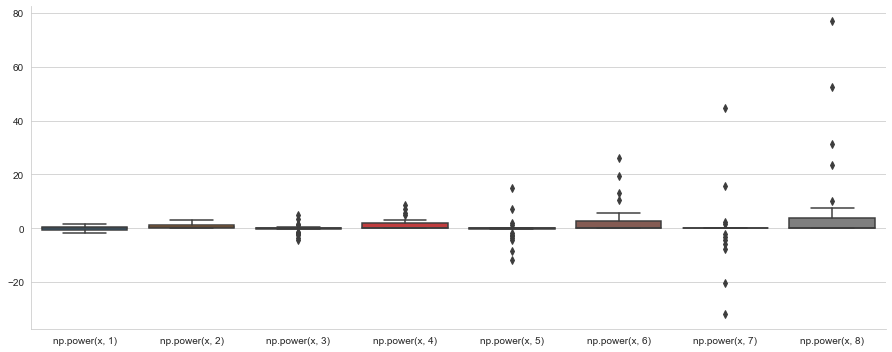

In [39]:
sns.catplot(data = pd.DataFrame(X_sk, columns=feature_names), kind='box', aspect=2.5)

plt.show()

Standardize the features such as the penalty term is more consistent for each feature in the data set.

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
X_std = StandardScaler().fit_transform(X_sk)

In [42]:
print( type( X_std ) )

<class 'numpy.ndarray'>


In [43]:
print( X_std.shape )

(30, 8)


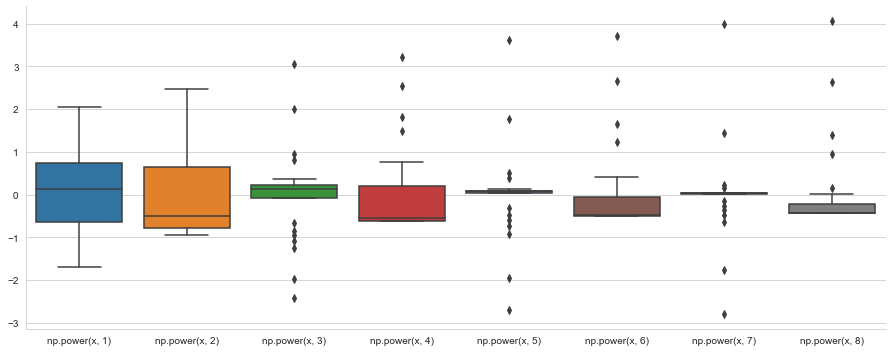

In [44]:
sns.catplot(data = pd.DataFrame(X_std, columns=feature_names), kind='box', aspect=2.5)

plt.show()

Execute the cross-validation again, but this using the standardized features with our lasso regresion model.

In [45]:
lasso_cv_std = LassoCV(cv=kf05, alphas=lasso_cv.alphas_, max_iter=10001).fit(X_std, y_sk.ravel())

What's the optimal value of `alpha`?

In [46]:
lasso_cv_std.alpha_

0.3519822152089929

In [47]:
pd.DataFrame({'no_penalty': [lm_fit.intercept_] + list(lm_fit.coef_),
             'best_lasso': [lasso_cv.intercept_] + list(lasso_cv.coef_),
             'best_lasso_w_std': [lasso_cv_std.intercept_] + list(lasso_cv_std.coef_)})

,no_penalty,best_lasso,best_lasso_w_std
0,2.291462,0.008966,-2.293037
1,-2.168089,0.000000,0.000000
2,-5.443974,-2.503179,-2.780110
3,8.497162,0.000000,0.000000
4,-14.758091,-0.165434,0.000000
5,-7.583896,0.000000,0.000000
6,14.325002,-0.000000,0.000000
7,1.863328,0.026589,0.000000
8,-3.188322,-0.000000,0.000000


Visualize the MSE path for the lasso model fit with the standardized features.

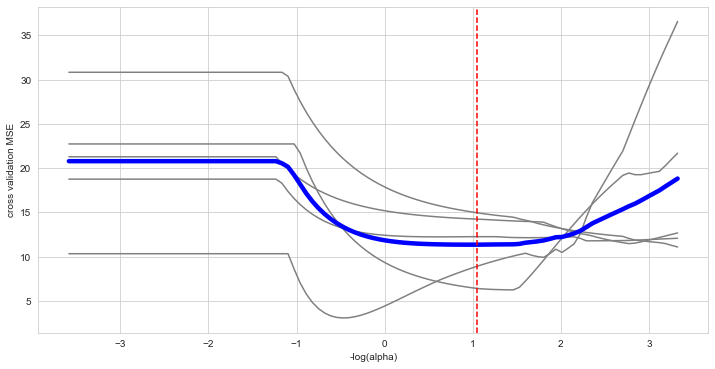

In [48]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(-np.log(lasso_cv_std.alphas_), lasso_cv_std.mse_path_, color='grey')
ax.plot(-np.log(lasso_cv_std.alphas_), lasso_cv_std.mse_path_.mean(axis=1), color='blue', linewidth=4.5)
ax.axvline(x = -np.log(lasso_cv_std.alpha_), color='red', linestyle='dashed')
ax.set_xlabel('-log(alpha)')
ax.set_ylabel('cross validation MSE')

plt.show()

## Standardization and cross-validation

What we just did, is not truly correct. We standardized using the entire data set, **before** applying cross-validation.

Standardization required calculating the mean (the sample average) and the sample standard deviation, based on the training set.

In [50]:
pd.DataFrame(X_sk, columns=feature_names).describe().loc[['mean', 'std']]

,"np.power(x, 1)","np.power(x, 2)","np.power(x, 3)","np.power(x, 4)","np.power(x, 5)","np.power(x, 6)","np.power(x, 7)","np.power(x, 8)"
mean,-0.117568,0.821675,-0.218694,1.422613,-0.324870,3.061768,-0.370610,7.259599
std,0.914172,0.879339,1.765749,2.327298,4.329818,6.283624,11.469911,17.460309


Calculate the mean and standard deviation for each feature associated with the separate cross-validation folds.

In [51]:
train_summary_stat_list = []

for ii, (train_id, test_id) in enumerate(kf05.split(X_sk)):
    train_summary_stat_list.append(pd.DataFrame(X_sk[train_id], columns=feature_names).describe().loc[['mean', 'std']])
    
    train_summary_stat_list[ii]['fold_id'] = ii

In [52]:
len( train_summary_stat_list )

5

In [53]:
train_summary_stat_df = pd.concat(train_summary_stat_list)

In [54]:
train_summary_stat_df

,"np.power(x, 1)","np.power(x, 2)","np.power(x, 3)","np.power(x, 4)","np.power(x, 5)","np.power(x, 6)","np.power(x, 7)","np.power(x, 8)",fold_id
mean,-0.103628,0.974081,-0.252411,1.761594,-0.397347,3.821156,-0.459654,9.072091,0
std,1.002610,0.920923,1.980104,2.495675,4.858990,6.839230,12.877773,19.163817,0
mean,-0.173770,0.683216,-0.266997,1.025324,-0.515763,1.945889,-1.172545,4.135329,1
std,0.825477,0.763429,1.398609,1.793914,3.094184,4.434274,7.554281,11.417321,1
mean,-0.046151,0.825099,-0.020595,1.383536,0.187914,2.893967,1.008659,6.722711,2
std,0.926688,0.856331,1.737627,2.240001,4.167046,6.036939,10.962771,16.913549,2
mean,-0.165737,0.795401,-0.354631,1.400648,-0.606807,3.132583,-0.939240,7.719380,3
std,0.895165,0.895196,1.771314,2.451100,4.531258,6.771421,12.356229,19.089613,3
mean,-0.098552,0.830578,-0.198837,1.541960,-0.292345,3.515247,-0.290271,8.648483,4
std,0.925503,0.942946,1.904423,2.558024,4.803067,6.946328,12.835214,19.321767,4


Reshape to long-format to support visualizing with Seaborn.

In [55]:
train_summary_stat_lf = train_summary_stat_df.reset_index().\
melt(id_vars=['index', 'fold_id'], value_vars=feature_names, ignore_index=True)

In [56]:
train_summary_stat_lf

,index,fold_id,variable,value
0,mean,0,"np.power(x, 1)",-0.103628
1,std,0,"np.power(x, 1)",1.002610
2,mean,1,"np.power(x, 1)",-0.173770
3,std,1,"np.power(x, 1)",0.825477
4,mean,2,"np.power(x, 1)",-0.046151
...,...,...,...,...
75,std,2,"np.power(x, 8)",16.913549
76,mean,3,"np.power(x, 8)",7.719380
77,std,3,"np.power(x, 8)",19.089613
78,mean,4,"np.power(x, 8)",8.648483


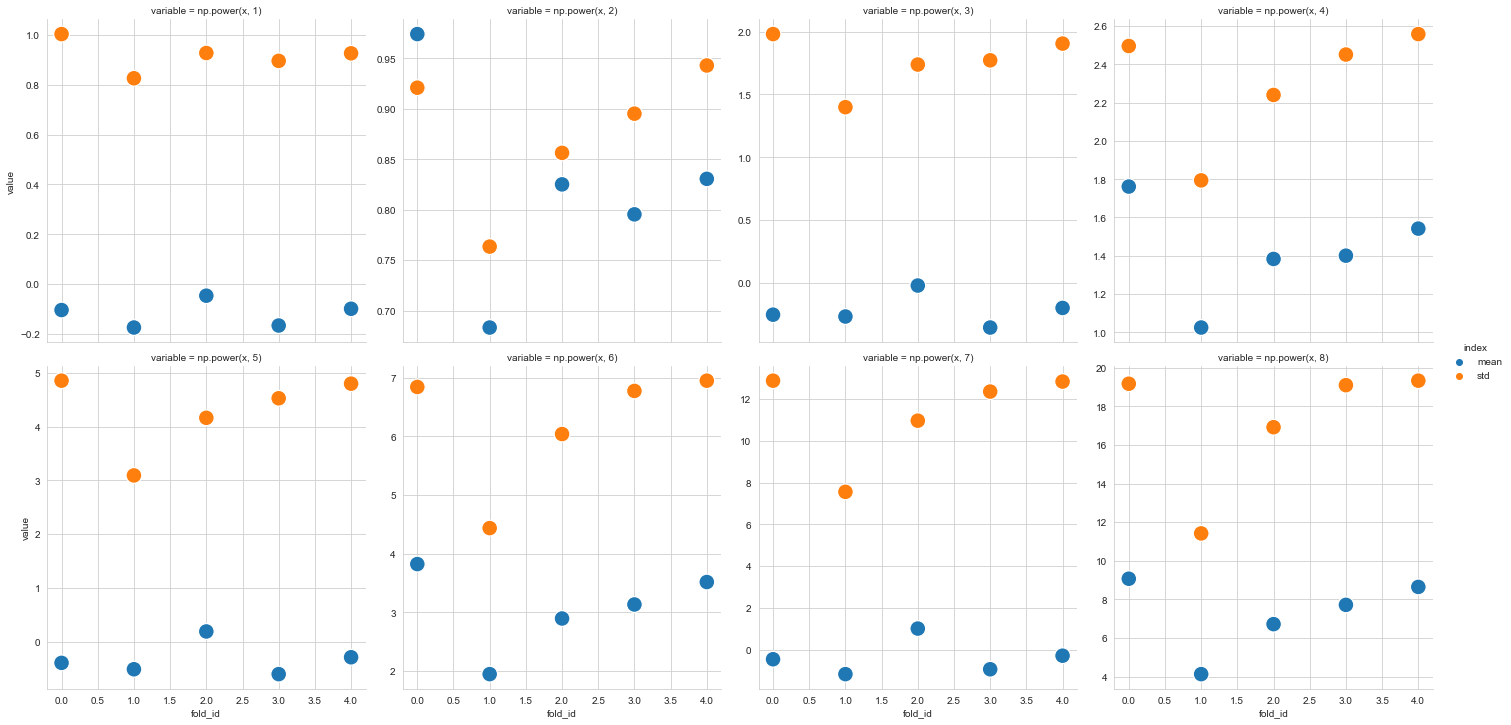

In [57]:
sns.relplot(data = train_summary_stat_lf, x='fold_id', y='value', col='variable', hue='index',
           col_wrap=4, s=250, facet_kws={'sharey': False})

plt.show()

The summary statistics for each feature are different across the folds.

The correct way to apply cross-validation with preprocessing is:

Define resampling scheme.

For each fold perform the followin steps:

* Apply the preprocessing to the training set (in sklearn terms you must fit then transform)

* Fit the model using the preprocessed training features

* Apply the preprocessing to the fold's test set (in sklearn terms you must transform)

* Predict the hold out test using the preprocessed features

* Calculate the error at each test point

* Summarize the error within the fold

### Create a pipeline

Create a "pipeline" of a series of steps to be performed within each cross-validation fold. Another term is the workflow or the work orders.

In [58]:
from sklearn.pipeline import Pipeline

We will still tune a lasso model, but we will not use the built-in cross-validation method instead we will use the more general `GridSearchCV()` function.

In [59]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

We must first initialize the objects that we will apply at each step. In our case, that corresponds to a standardization and a lasso model.

In [60]:
standardize_features = StandardScaler()

### define a lasso model object but DO NOT specify alpha
lasso_mod = Lasso(fit_intercept=True, max_iter=10001)

Define the pipeline or the workflow of steps that we execute per fold. The steps must be named and given the object. The name and object are supplied within a tuple.

In [61]:
lasso_workflow = Pipeline( steps = [('std_scale', standardize_features), ('lasso', lasso_mod)] )

In [62]:
lasso_workflow.steps

[('std_scale', StandardScaler()), ('lasso', Lasso(max_iter=10001))]

We must define the grid of candidate tuning parameter values for `GridSearchCV()` to use. The grid must be defined within a dictionary where the keys represet the parameter names. The keys associated with a pipeline must be named as:

`<step name>__<model parameter name>`

The step name and model parameter name are separated by a "dunder" or double-underscore.

In [63]:
lasso_grid = {'lasso__alpha': lasso_cv.alphas_}

Initialize the `GridSearchV()` object providing the pipeline, the tuning grid, the cross-validation object, and how we will score the model. The options for scoring:  

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

We will score based on R-squared.

In [64]:
lasso_search = GridSearchCV(lasso_workflow, param_grid=lasso_grid, cv=kf05, scoring='r2')

Execute the cross-validation, use the original un-standardized input-features.

In [65]:
lasso_search_results = lasso_search.fit(X_sk, y_sk.ravel())

In [66]:
dir(lasso_search_results)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_check_n_features',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_features_in_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_

Look at the optimally identified `alpha` value.

In [67]:
lasso_search_results.best_params_

{'lasso__alpha': 0.6116749852952289}

What's the associated best r-squared?

In [68]:
lasso_search_results.best_score_

0.1965418190560429

The underlying lasso model must be accessed through the `.best_estimator_.named_steps`

In [69]:
lasso_search_results.best_estimator_

Pipeline(steps=[('std_scale', StandardScaler()),
                ('lasso', Lasso(alpha=0.6116749852952289, max_iter=10001))])

In [70]:
lasso_search_results.best_estimator_.named_steps

{'std_scale': StandardScaler(),
 'lasso': Lasso(alpha=0.6116749852952289, max_iter=10001)}

In [71]:
lasso_search_results.best_estimator_.named_steps['lasso']

Lasso(alpha=0.6116749852952289, max_iter=10001)

In [72]:
lasso_search_results.best_estimator_.named_steps['lasso'].intercept_

-2.2930368375447947

In [73]:
lasso_search_results.best_estimator_.named_steps['lasso'].coef_

array([ 0.        , -2.52041686,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ])

The cross-validation performance metrics per fold per value of `alpha` are tricky to extract. They are stored in the `.cv_results_`.

In [75]:
type( lasso_search_results.cv_results_)

dict

In [76]:
lasso_search_results.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_lasso__alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Visualize the R-squared performance averaged over the folds with the standard error on the average.

In [77]:
lasso_cv_summary = pd.DataFrame({'alpha': lasso_search_results.cv_results_['param_lasso__alpha'].data.astype('float64'),
                                'mean_test_score': lasso_search_results.cv_results_['mean_test_score'],
                                'std_test_score': lasso_search_results.cv_results_['std_test_score']})

lasso_cv_summary['neg_log_alpha'] = - np.log( lasso_cv_summary.alpha )

### BECAUSE we used 5-fold cross-validation!!!!
lasso_cv_summary['mean_se'] = lasso_cv_summary.std_test_score / np.sqrt(5)

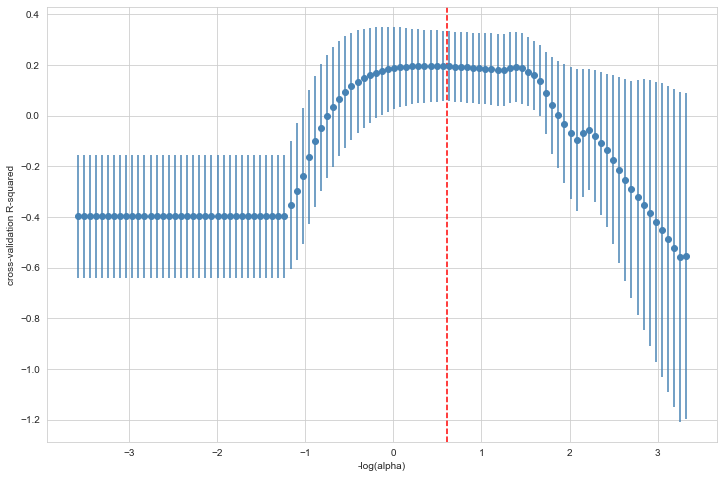

In [78]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.errorbar(x=lasso_cv_summary.neg_log_alpha, 
            y=lasso_cv_summary.mean_test_score,
           yerr=lasso_cv_summary.mean_se,
           fmt='o', color='steelblue', ecolor='steelblue')

ax.axvline(x=lasso_search_results.best_params_['lasso__alpha'], linestyle='--', color='red')

ax.set_xlabel('-log(alpha)')
ax.set_ylabel('cross-validation R-squared')

plt.show()